In [28]:
symbol = 'BTCUSDT'
tf = '1d'

In [29]:
import pandas as pd
df = pd.read_csv(f'./data/{symbol}_{tf}.csv')
df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms')
df.set_index('Date',inplace=True)
df = df[['Open', 'High', 'Low', 'Close', 'Volume','Taker_buy_base']]
df.index = pd.to_datetime(df.index)

In [30]:
import pandas as pd
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import AverageTrueRange
from ta.trend import ADXIndicator

def add_indicators(df):
    df.columns = df.columns.str.capitalize()
    df['Delta_volume'] = df['Taker_buy_base'] - (df['Volume'] - df['Taker_buy_base'])
    df['cvd'] = df['Delta_volume'].cumsum()
    df['cvd_rolling'] = df['cvd'].rolling(12).mean()
    df['adx'] = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close']).adx()
    df['obv'] = OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()
    df['atr'] = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()
    df['cvd_momentum'] = df['cvd_rolling'] - df['cvd_rolling'].shift(5)

    df['ret_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['ret_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['ret_15'] = df['Close'] / df['Close'].shift(15) - 1

    df['vol_compression'] = df['atr'] / df['Close'].rolling(14).std()

    df.dropna(inplace=True)  
    # df['lower_wick'] = df[['Close', 'Open']].min(axis=1) -  df['Low']
    # df['upper_wick'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    # df['body_size'] = df['Close'] - df['Open']
    df.drop(columns=['High', 'Open', 'Low', 'Volume', 'Taker_buy_base','cvd','Delta_volume'], inplace=True)
    
    return df


In [31]:
data = add_indicators(df)
data

,Close,cvd_rolling,adx,obv,atr,cvd_momentum,ret_5,ret_10,ret_15,vol_compression
Date,,,,,,,,,,
2024-03-17,68393.48,13370.433776,0.000000,145567.315358,4094.063436,4616.255560,-0.042805,0.023499,0.103347,1.526211
2024-03-18,67609.99,13838.368154,0.000000,89876.234478,3972.401762,3706.592543,-0.074754,-0.007548,0.071237,1.473623
2024-03-19,61937.40,13689.119587,0.000000,-11129.090392,4157.880922,2200.759075,-0.132395,-0.093333,-0.092435,1.398216
2024-03-20,67840.51,13495.371302,0.000000,79291.495528,4384.103713,1022.106567,-0.023875,-0.016175,0.064599,1.512115
2024-03-21,65501.27,13285.325444,0.000000,25934.015508,4336.057734,431.287172,0.003073,-0.091246,-0.008669,1.453623
...,...,...,...,...,...,...,...,...,...,...
2025-05-28,107781.78,-226663.298064,29.644425,95299.478048,2971.154396,-1013.325889,0.004319,0.012470,0.035331,1.170171
2025-05-29,105589.75,-227019.447082,27.865145,75464.776888,3013.861225,-1322.764675,-0.020157,0.000152,0.020114,1.260214
2025-05-30,103985.48,-227650.123924,26.290794,51758.278898,2990.879709,-1728.877491,-0.046041,-0.026809,0.002137,1.283674


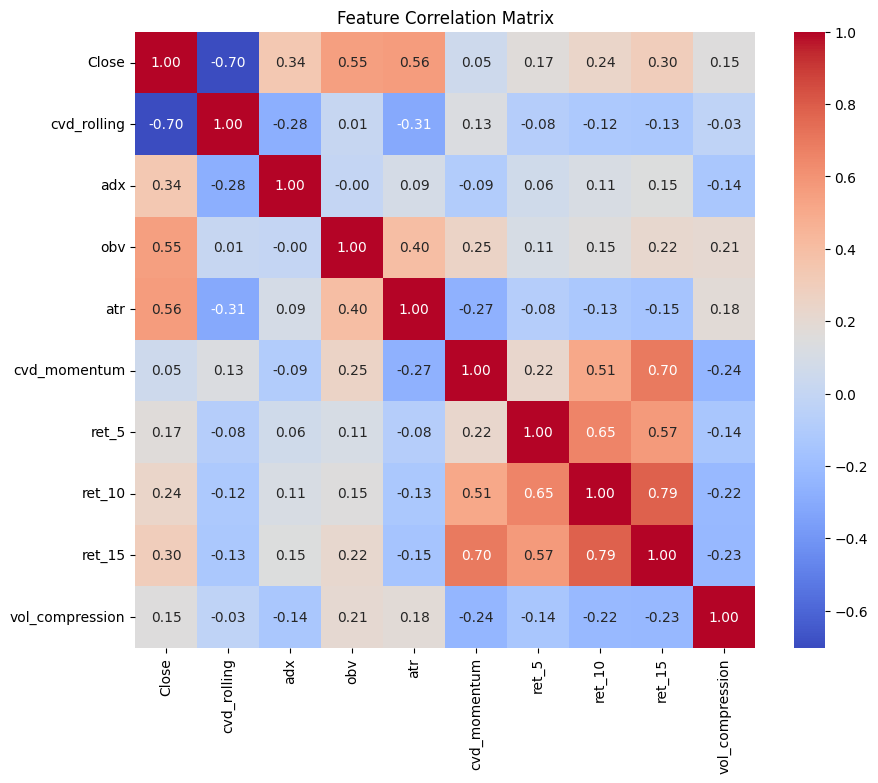

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe with OHLCV + indicators
correlation_matrix = data.corr()

# Visualize
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [33]:
def add_target_column(df, profit_threshold=0.05, lookahead=50):
    target = []

    for i in range(len(df)):
        entry_price = df['Close'].iloc[i]
        profit_long = 0
        valid_bars = df.iloc[i+1:i+1+lookahead]

        for j in range(len(valid_bars)):
            curr_price = valid_bars['Close'].iloc[j]
            profit_long =  max(profit_long,(curr_price - entry_price) / entry_price)

        if profit_long >= profit_threshold:
            target.append(1)
        else:
            target.append(0)

    df_copy = df.copy()
    df_copy['Target'] = target
    df_target = df_copy[['Target']]
    return df_target


In [34]:
df_target = add_target_column(data,profit_threshold=0.05,lookahead=10)

In [35]:
data = pd.concat([data, df_target], axis=1)
data = data[:-30]

In [36]:
data['Target'].value_counts()

Target
0    240
1    172
Name: count, dtype: int64

In [37]:
X = data.drop(columns=['Target'])
y = data['Target']

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
X_scaled[0]

array([-0.52294755,  1.55177517, -2.38099214,  1.61838405,  1.12082523,
        2.84741201, -0.85221535,  0.17207906,  0.92294032,  0.2834286 ])

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

In [41]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight='balanced',max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [42]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# y_pred = clf.predict(X_train)
# print("Accuracy:", accuracy_score(y_train, y_pred))
# print("Classification Report:\n", classification_report(y_train, y_pred))    
# print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))

In [43]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# y_pred = clf.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))    
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [44]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# # Train Random Forest
# rf = RandomForestClassifier(
#     n_estimators=200,     # try 100–500 for stability
#     max_depth=None,       # let it grow fully (can tune later)
#     random_state=42,
#     class_weight='balanced'  # helps if classes are imbalanced
# )

# rf.fit(X_train, y_train)

# # Predictions
# y_pred = rf.predict(X_test)
# y_prob = rf.predict_proba(X_test)[:, 1]

# # Evaluation
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))
# print("ROC AUC:", roc_auc_score(y_test, y_prob))

# # Feature Importance
# import matplotlib.pyplot as plt
# import seaborn as sns

# feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=feature_importance.values, y=feature_importance.index)
# plt.title("Feature Importance")
# plt.tight_layout()
# plt.show()

In [45]:
# test_results = pd.DataFrame({
#     'Actual': y_test,   
#     'Predicted': y_pred
# })

In [46]:
# test_results

In [47]:
# test_results.to_csv("./intermediate/test_results.csv", index=True)

In [48]:
# test_results['Actual'].value_counts()

In [49]:
# ((test_results['Actual'] == 1) & (test_results['Predicted'] == 1)).sum()

In [50]:
# ((test_results['Actual'] == 0) & (test_results['Predicted'] == 1)).sum()

C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [20:23:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[35 18]
 [11 19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.66      0.71        53
           1       0.51      0.63      0.57        30

    accuracy                           0.65        83
   macro avg       0.64      0.65      0.64        83
weighted avg       0.67      0.65      0.66        83

ROC AUC: 0.5974842767295598


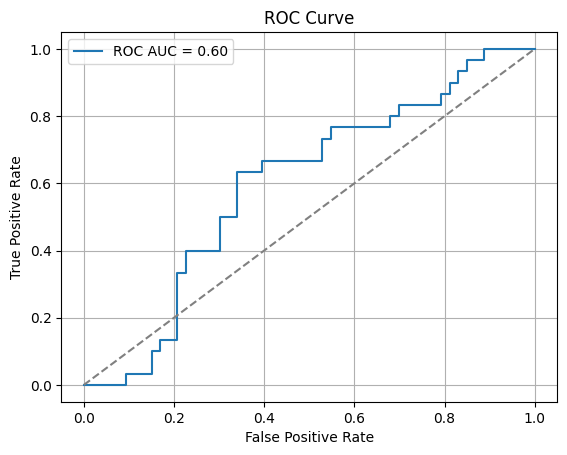

In [57]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt

# Compute class imbalance weight
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Train XGBoost
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Optional: Threshold tuning
threshold = 0.9  # try 0.2 to 0.5 depending on precision-recall tradeoff
y_pred = (y_prob > threshold).astype(int)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [58]:
test_results = pd.DataFrame({
    'Actual': y_test,   
    'Predicted': y_pred
})

In [59]:
test_results.to_csv("./intermediate/test_results.csv", index=True)

In [60]:
test_results['Predicted'].value_counts()

Predicted
0    46
1    37
Name: count, dtype: int64